In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

%matplotlib inline 
plt.style.use('fivethirtyeight')

## Ended up not using this due to poor model performance 

Further explanation at the end of notebook.

### Read in Data

In [2]:
df = pd.read_csv('../data/clean_df.csv')

In [3]:
df.head()

date  incident_id governorate        district  \
0  2015-03-26            1       Sanaa  bani al-harith   
1  2015-03-26            2       Sanaa  bani al-harith   
2  2015-03-26            3       Sanaa  bani al-harith   
3  2015-03-26            4       Sanaa      al-sab'ein   
4  2015-03-26            5       Sanaa      al-thawrah   

                       area                        target  \
0                Al-Rahabah            Al-Daylami Airbase   
1                   Airport  Sana'a International Airport   
2  Al-Sonblah Neighbourhood              Residential Area   
3                Al-Nahdain           Presidential Palace   
4                Al-Nahdhah  Former 1st Armoured Division   

              main_category      sub_category  min_air_raids  max_air_raids  \
0  military_security_target     military site              1            2.0   
1            infrastructure         transport              1            2.0   
2                  civilian  residential area              1            2.0   
3  military_security_target     military site              1            2.0   
4  military_security_target     military site              1            2.0   

   civilian_casualties  fatalities  woman_fatalities  child_fatalities  \
0                    0           0                 0                 0   
1                    0           0                 0                 0   
2                   29          21                 3                14   
3                    0           0                 0                 0   
4                    0           0                 0                 0   

   injured  woman_injured  child_injured confirmed_time time_of_day  
0        0              0            0.0              2     morning  
1        0              0            0.0              2     morning  
2        8              0            7.0              2     morning  
3        0              0            0.0              3     morning  
4        0              0            0.0              3     morning

## Resetting index to datetime index

In [4]:
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)

In [5]:
df = pd.get_dummies(df, columns=['main_category', 'sub_category', 'time_of_day', 'confirmed_time'])

## Creating numerical category column "label" for values in governorate column

In [6]:
len(df['governorate'].unique())

22

In [7]:
df['label'] = pd.Categorical(df['governorate'])

In [8]:
df['label'] = df['label'].cat.codes

In [9]:
df['label']

date
2015-03-26    18
2015-03-26    18
2015-03-26    18
2015-03-26    18
2015-03-26    18
              ..
2020-12-31    18
2020-12-31    18
2020-12-31    18
2020-12-31    18
2020-12-31    14
Name: label, Length: 22485, dtype: int8

## Setting up/scaling training/testing data 

In [10]:
X = df.drop(columns=['area', 'target', 'governorate', 'district', 'label'])
y = df['label']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6, shuffle=False)

In [12]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

## Converting y to one hot encoded columns for classes

In [13]:
y_train = to_categorical(y_train, num_classes=22) 
y_test = to_categorical(y_test, num_classes=22)

## Setting up the model to predict governorate

In [14]:
input_shape = X_train_ss[0].shape

In [15]:
model = Sequential()

model.add(Dense(256, input_shape=input_shape, activation="relu"))

model.add(Dense(128, activation="relu"))

model.add(Dense(64, activation="relu"))

model.add(Dense(64, activation="relu"))

model.add(Dense(32, activation='relu'))

model.add(Dense(22, activation='softmax')) # Using softmax for multiclass output predictions

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc']) 
# multiclass output = categorical crossentropy for loss function
history = model.fit(X_train_ss, y_train, validation_data=(X_test_ss, y_test), epochs=100, batch_size = 512)

Epoch 1/100
33/33 [==============================] - 2s 32ms/step - loss: 2.8146 - acc: 0.1723 - val_loss: 2.3565 - val_acc: 0.2930
Epoch 2/100
33/33 [==============================] - 0s 6ms/step - loss: 2.1903 - acc: 0.3182 - val_loss: 2.2894 - val_acc: 0.2981
Epoch 3/100
33/33 [==============================] - 0s 6ms/step - loss: 2.0843 - acc: 0.3391 - val_loss: 2.3302 - val_acc: 0.2992
Epoch 4/100
33/33 [==============================] - 0s 6ms/step - loss: 2.0211 - acc: 0.3569 - val_loss: 2.3667 - val_acc: 0.3042
Epoch 5/100
33/33 [==============================] - 0s 6ms/step - loss: 1.9964 - acc: 0.3605 - val_loss: 2.4158 - val_acc: 0.3001
Epoch 6/100
33/33 [==============================] - 0s 7ms/step - loss: 1.9548 - acc: 0.3736 - val_loss: 2.4045 - val_acc: 0.2832
Epoch 7/100
33/33 [==============================] - 0s 6ms/step - loss: 1.9467 - acc: 0.3743 - val_loss: 2.4091 - val_acc: 0.2882
Epoch 8/100
33/33 [==============================] - 0s 6ms/step - loss: 1.9272 - 

## Plotting Loss and accuracy

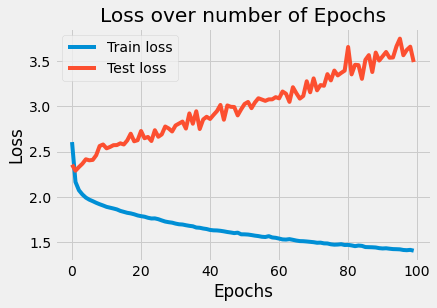

In [19]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of Epochs')
plt.legend();

Very poor performance of ~ 3.6-3.8 for testing data, could not manipulate to get a decent result. This graph shows how
as the loss is minimized the testing loss is almost immediately diverging from the training loss. This would indicate
the model will not be usefull as it over fits to the training data and does not provide useful information.

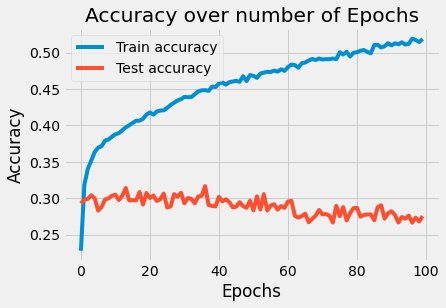

In [18]:
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over number of Epochs')
plt.legend();

Again, this model is showing how poor it is by having an accuracy score of ~.30 for testing data.  This shows how the
trained model is accurate when presented the training data and, inaccurate when presented the testing data.

## Ended up not using this due to poor model performance 